In [ ]:
#References
#https://towardsdatascience.com/another-twitter-sentiment-analysis-bb5b01ebad90
#https://pasaentuciudad.com.mx/data-to-model-to-api-an-end-to-end-approach/
#https://github.com/The-AI-Summer/Deep-Learning-In-Production/tree/master/2.%20Writing%20Deep%20Learning%20code:%20Best%20Practises

# Install and import the necessary dependencies

In [ ]:
def create_dir(dir): #TO-DO: REMOVE

  if not os.path.exists(dir):
    os.makedirs(dir)
    print("Created Directory : ", dir)
  else:
    print("Directory already existed : ", dir)
  return dir

create_dir('/content/mydrive/SentimentAnalysis')

In [ ]:

from google.colab import drive

#This will prompt for authorization.
drive.mount('/content/drive')

#Create a symbolic link, in order no to be able to save weights on drive. Otherwise it gives an error. 
!ln -s /content/drive/My\ Drive /content/mydrive


#Install requirements
%cd mydrive/SentimentAnalysis
!pip install -r requirements.txt 


import os
import sys
import requests, zipfile, io

import pandas as pd
import re

import wordninja, contractions, emoji #preprocessing.py

import seaborn as sns #visualization.py
import nltk #visualization.py
from nltk.corpus import stopwords #visualization.py

import tensorflow as tf

from sklearn.model_selection import train_test_split

sys.path.insert(0,'/content/mydrive/SentimentAnalysis/src/utils')
import Config

sys.path.insert(0,'/content/mydrive/SentimentAnalysis/src/data')
import dataloader

sys.path.insert(0,'/content/mydrive/SentimentAnalysis/src/models/')
import BaseModel,LSTM

sys.path.insert(0,'/content/mydrive/SentimentAnalysis/configs')
from config_main import CFG


# Load data

In [ ]:

"""
Creates a directory, if it does not exist.

Input: directory
Output: directory
"""
def create_dir(dir):
  if not os.path.exists(dir):
    os.makedirs(dir)
    print("Created Directory : ", dir)
  else:
    print("Directory already existed : ", dir)
  return dir

  
input_path = os.path.join('/content/mydrive/SentimentAnalysis/datasets', CFG['data']['url'])
# download_dataset('/content/mydrive/SentimentAnalysis/datasets', CFG)

#Download and unzip dataset
!wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
create_dir(input_path)
!unzip trainingandtestdata.zip -d "$input_path" 

#Read unzipped data
train_data_df = pd.read_csv(os.path.join(input_path, 'training.1600000.processed.noemoticon.csv'),  encoding='latin-1', usecols=[0,5], names=['sentiment','tweet'])

#Print dataset info
print(train_data_df.info())  


In [67]:
import wget
url_name = config_f['data']['url']
print(url_name)
wget.download(url_name)

http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip


'trainingandtestdata.zip'

In [58]:
sys.path.insert(0,'/content/mydrive/SentimentAnalysis/src/data')
import dataloader


In [84]:
dataloader.download_dataset('/content/mydrive/SentimentAnalysis/datasets', CFG)

/content/mydrive/SentimentAnalysis/datasets/Sentiment140


In [83]:
from importlib import reload  # Py3 only; unneeded in py2.
foo = reload(dataloader)

# Preprocess data

In [ ]:

"""
Removes the emojis from a tweet.
Input:tweet for cleaning from emojis(str)
Output: tweet without emojis(str)
"""
def strip_emoji(tweet):
  new_tweet = re.sub(emoji.get_emoji_regexp(), r"", tweet)
  return new_tweet.strip()


"""
Removes the urls from a tweet.
Input:tweet for cleaning from urls(str)
Output: tweet without urls(str)
"""
def strip_urls(tweet):
  new_tweet = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', tweet, flags=re.MULTILINE)
  return new_tweet.strip()


"""
Removes the tags from a tweet.
Input:tweet for cleaning from tags(str)
Output: tweet without tags(str)
"""
def remove_tags(tweet):
  return " ".join([token for token in tweet.split() if not token.startswith("@")])


"""
Performs tweet preprocessing, by removing emojis, urls and tags.
Input:tweet for preprocessing(str)
Output: preprocessed tweet(str)
"""
def preprocess_tweet(tweet):
  tweet = remove_tags(strip_emoji(strip_urls(tweet)))
  tweet = contractions.fix(" ".join(wordninja.split(tweet)))
  tweet = [token.lower() for token in tweet.split() if (len(set(token))>1)]
  return " ".join(tweet)


# Preprocessing tweets data
print("Cleaning and parsing the tweets...\n")
train_data_df = train_data_df.iloc[0:10000] #TO-DO: Remove
train_data_df.tweet = train_data_df.tweet.apply(preprocess_tweet)
print("Finished!\n")

# Preprocessing labels to have classes 0 and 1
train_data_df.sentiment = train_data_df.sentiment.apply(lambda value: 1 if value==4 else value)

print("Sentiment values: ")
print(train_data_df.sentiment.value_counts())

print(train_data_df.head(5)) 



# Analyze data
Estimating the vocabulary size and the vector sequence length to be fed to the model every instance is a crucial step for a good model.

This is achieved by analyzing the training dataset, by plotting the 
distribution of tweet lengths across the training data.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Total Unique Words: 2799
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Total words 12739
Total stop words 5707
Ratio of total words to total stop words: 2.232171018048011


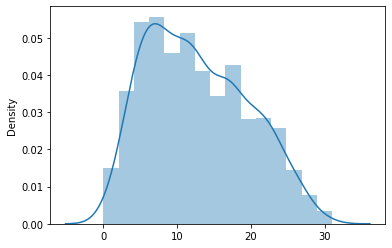

In [8]:
"""
Return the length of a tweet.
Input: tweet(str)
Output: length(int)
"""
def tweet_length(tweet):
  return len([token for token in tweet.split()])

tweet_lengths = [tweet_length(tweet) for tweet in train_data_df.tweet.tolist()]
sns.distplot(tweet_lengths)

# Unique words
unique_words = set([token for tweet in train_data_df.tweet for token in tweet.split()])
print("Total Unique Words:", len(unique_words))

# Counting Total Words and Stop Words
nltk.download("stopwords")
stop_words = stopwords.words("english")
total_words = [token for tweet in train_data_df.tweet for token in tweet.split()]
total_stop_words = [token for tweet in train_data_df.tweet for token in tweet.split() if token in stop_words]
print('Total words', len(total_words))
print('Total stop words', len(total_stop_words))
print('Ratio of total words to total stop words:', len(total_words)/len(total_stop_words))

# Train model


In [13]:
from importlib import reload  # Py3 only; unneeded in py2.
foo = reload(LSTM)

In [14]:
model = LSTM.LSTM(CFG)
model.split_training_data(train_data_df)
model.data_vectorization(75000, 50)
model.build_model()
model.train()

# Save/Serialize model

In [ ]:
# Saving Model
MODEL_DIR = "/content/mydrive/SentimentAnalysis/models"
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

# Check the path
print('\nSaved model:')
!ls -l {export_path}

# Using SavedModelCLI to check if model is persisted properly
!saved_model_cli show --dir {export_path} --all

In [ ]:
model.evaluate() #TO-DO

# Evaluate model

In [ ]:
# Loading and Evaluation of Model

test_data_df = pd.read_csv(os.path.join(input_path, 'testdata.manual.2009.06.14.csv'),  encoding='latin-1', usecols=[0,5], names=['sentiment','tweet'])
print(test_data_df.sentiment.value_counts()/test_data_df.shape[0])

# Preprocessing tweets data
print("Cleaning and parsing the tweets...\n")
test_data_df = test_data_df.iloc[0:1000] #TO-DO: Remove
test_data_df.tweet = test_data_df.tweet.apply(preprocess_tweet) #TO-DO
print("Finished!\n")

test_data_df = test_data_df[test_data_df.sentiment!=2] #Remove intermediate polarities
test_data_df.sentiment.value_counts()/test_data_df.shape[0]

test_data_df.sentiment = test_data_df.sentiment.apply(lambda value: 1 if value==4 else value)

print(test_data_df.sentiment.value_counts()/test_data_df.shape[0])


# Preprocessing labels to have classes 0 and 1
test_data_df.sentiment = test_data_df.sentiment.apply(lambda value: 1 if value==4 else value)

#Create data pipeline for test
test_dataset = create_data_pipeline(test_data_df.tweet, test_data_df.sentiment, batch_size=128, is_training=False)


model = tf.keras.models.load_model(export_path)
model.evaluate(test_dataset)